In [407]:
%matplotlib inline
import pandas as pd
from random import choice
from copy import deepcopy
import numpy as np
import seaborn as sns
import matplotlib.dates as mdate
from matplotlib import pyplot as plt
import calendar
import time
from mpl_toolkits.basemap import Basemap
from datetime import timedelta
import matplotlib.patches as patches

In [87]:
# Date formatting info
date_fmt = "%b '%y" # eg Jan '88
date_formatter = mdate.DateFormatter(date_fmt)

In [198]:
# Read the file, drop non-matches and assign a random topic
df = pd.read_json("/Users/hep/Downloads/CS_STATS_id_title_tag_MAK-matched_GRID-matched.json")
df = df.loc[df.matched==True]
df.sort_values("date",inplace=True)
df["topic"] = df.apply(lambda x : choice(["A","B","C"]),axis=1)
df["fixed_date"] = df.date.apply(lambda d : mdate.epoch2num(d/1000))
df["month"] = df.date.apply(lambda x: time.gmtime(x/1000).tm_mon)
df["year"] = df.date.apply(lambda x: time.gmtime(x/1000).tm_year)
df["quarter"] = np.ceil(df.month/3)

# Generate one row per institute
rows = []
for _,row in df.iterrows():
    insts = row["institutes"]
    lat_lon_scores = row["lat_lon_score"]
    # Match lat/lon/score/institute
    for inst,(lat,lon,score) in zip(insts,lat_lon_scores):
        # Create the new row and drop redundant data 
        _row = deepcopy(row)
        _row.drop(["institutes","lat_lon_score","matched"],inplace=True)
        _row["institute"] = inst
        _row["lat"] = lat
        _row["lon"] = lon
        _row["score"] = score
        rows.append(_row)

# Clear the cache and build a new dataframe
del df
df = pd.DataFrame(rows)
_df = deepcopy(df.loc[df.score > 0.99])

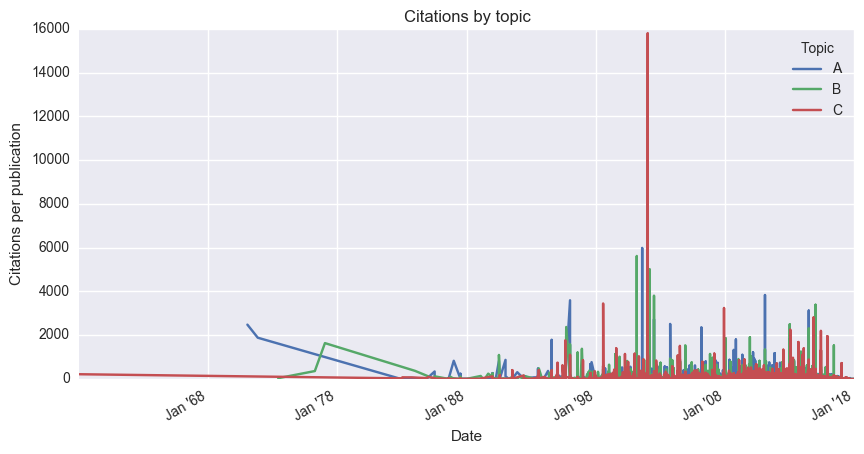

In [523]:
# Make a plot of number of citations to understand "rare" events
fig, ax = plt.subplots(figsize=(10,5))

# Loop over 
for _topic,grouped in _df.drop_duplicates("pid").groupby("topic"):
    ax = grouped.plot.line("fixed_date","citations",ax=ax,label=_topic)

# Format the labels
ax.set_title("Citations by topic")
ax.legend().set_title("Topic")
ax.set_ylabel("Citations per publication")
ax.set_xlabel("Date")
ax.xaxis_date()
ax.xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate()

In [509]:
'''Function to plot lat lon coordinates on a map'''
def make_map(df,ax=None,color="orange",alpha=0.3,s=1,embolden=None,**kwargs):
    # Convert lat lon to lists
    lats = list(df.lat)
    lons = list(df.lon)
    # Hack to brighten up markers: plot the marker <embolden> times
    if embolden:
        lats = lats*embolden
        lons = lons*embolden
    # If an axis hasn't been passed, create one
    if ax == None:
        fig,ax = plt.subplots(figsize=(10,5))
    # Make the basemap
    m = Basemap(projection='merc',llcrnrlat=-60,urcrnrlat=65,
                llcrnrlon=-170,urcrnrlon=190,lat_ts=2,resolution='c',)
    m.drawcoastlines(linewidth=0.05,color="white")
    m.drawcountries(linewidth=0.075,color="white")
    m.drawmapboundary(fill_color='black',linewidth=0)
    # Convert the coordiates to this projection
    lons,lats = m(lons,lats)
    # Scatter the data
    m.scatter(x=lons,y=lats,ax=ax,
              latlon=False,alpha=alpha,s=s,
              color=color,**kwargs)
    return ax


In [510]:
'''Test whether the dataframe row "test" is within 
6 months (before or after) dataframe row "event"'''
def within_six_months(test,event,before=True):
    # Get time delta (note "dates" are in epoch seconds)
    seconds = float(test.date - event.date)/1000
    delta = timedelta(seconds=seconds)
    # Convert to "months" (this is kind of rough)
    n_months = 12 * delta.days / 365
    # Evaluate
    if before:
        return n_months > -6 and n_months < 0
    else:
        return n_months < 6 and n_months > 0

In [511]:
'''Plot a map of dataframe rows within 6 months of the rows in 
"grouped_event", which are "rare events" with large numbers of
citations"
'''
def make_and_customise_map(grouped,grouped_event,before,polynom):
    # Pull out any of the rare events, for the date
    event = grouped_event.head(n=1)        
    event_date = datetime.datetime.fromtimestamp(event.date/1000)
    # Get the dataframe rows of grouped within 6 months of event
    condition = grouped.apply(func=within_six_months,
                              args=(event,before),axis=1)
    # Plot the rows on a map
    ax = make_map(grouped.loc[condition])
    make_map(grouped_event,ax,color="lime",embolden=100,
             alpha=1,s=20,marker=(5,2),zorder=10)

    # Generate prediction data for the two quarters before/after the event
    if before:
        title_text = "6 months before publication of '"+str(event.title.values[0])+"'"
        _epochs = [x.timestamp() for x in _dates
                   if (x > event_date - timedelta(days=365/2)) and (x < event_date)]
    else:
        title_text = "6 months after publication of '"+str(event.title.values[0])+"'"
        _epochs = [x.timestamp() for x in _dates
                   if (x < event_date + timedelta(days=365/2)) and (x > event_date)]
    
    # Calculate the % difference between total and expected
    total = condition.sum()
    expected = np.ceil(sum(polynom(_epochs)))
    pc_diff = np.ceil((total/expected - 1)*100)
    sign = ""
    if pc_diff > 0:
        sign = "+"
    
    # Top title
    ax.text(5e5, 17e6, title_text, color="plum", fontsize=12, weight="bold")

    # Summary of data
    ax.text(5e5, 2.5e6, "Total papers on topic: "+str(condition.sum()), color="white")
    ax.text(5e5, 1.5e6, "Expected: "+str(int(expected))+" ("+sign+str(int(pc_diff))+"%)", color="white")

    # 'Legend'
    ax.text(1.6e7, 3e6, "Institutes involved in the highly cited paper", color="white")
    ax.text(1.6e7, 2e6, "Institutes with new papers on topic", color="white")
    ax.scatter([1.55e7]*100,[3.2e6]*100,color="lime",marker=(5,2))
    ax.scatter([1.55e7]*100,[2.2e6]*100,color="orange",marker="+")
    ax.add_patch(patches.Rectangle((1.5e7,1.1e6),1.5e7,3.1e6,
                                   fill=False,edgecolor="white"))
    
    return ax

A 3662.1275 47276


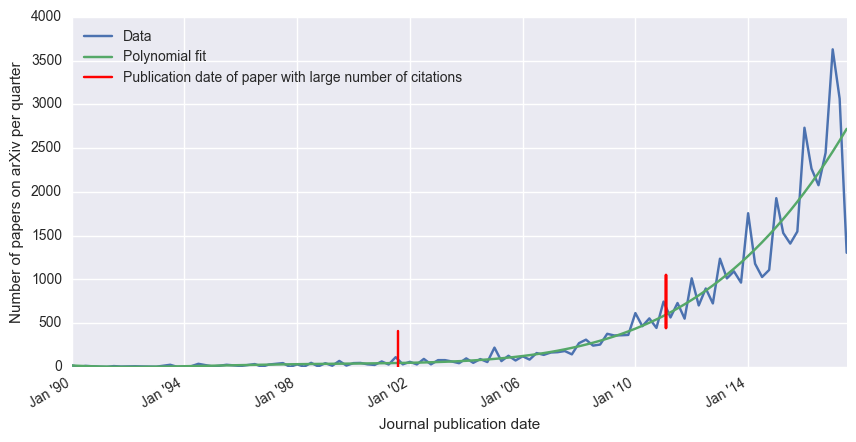

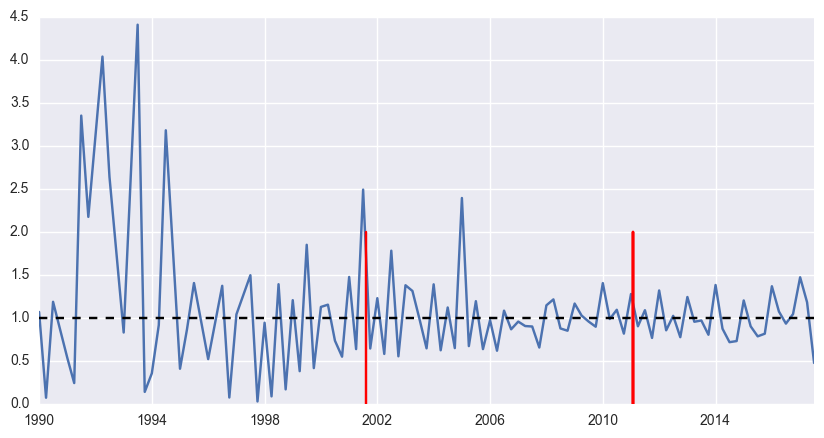

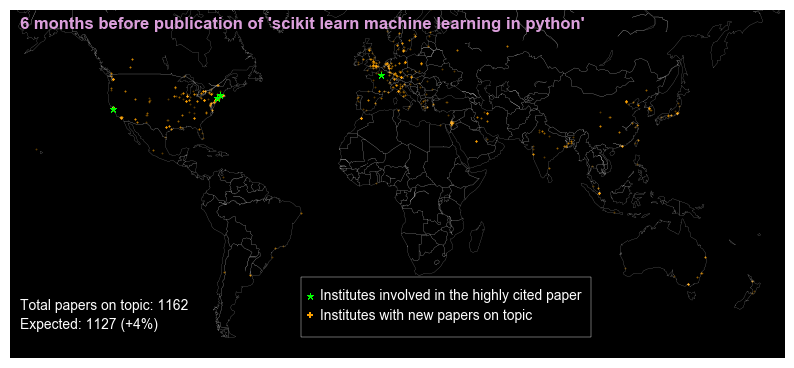

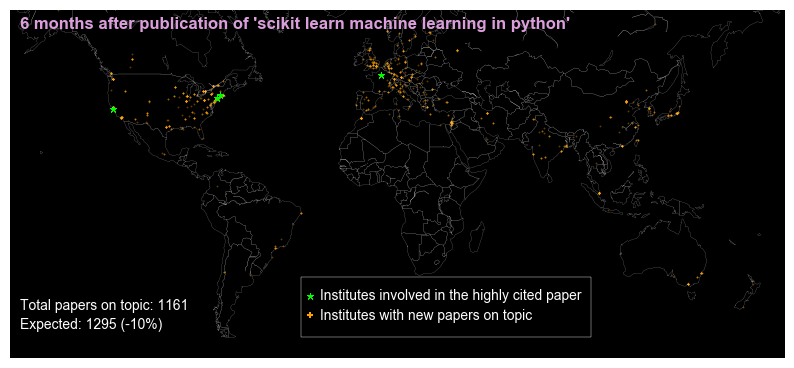

In [522]:
# Order of polynomial to fit
polyn = 4

# Plot number of publications by date per topic, identifying rare events
for _topic,grouped in _df.groupby("topic"):
    
    # Aggregate grouped by date and sum
    _counts = []
    _dates = []
    for (_year,_quarter),_grouped in grouped.groupby(["year","quarter"]):
        if _year < 1990:
            continue
        _counts.append(len(_grouped))
        _dates.append(datetime.datetime.strptime(str(int(3*(_quarter))-2)+" "+str(_year),'%m %Y'))
    _dates = _dates[:-2]
    _counts = _counts[:-2]
    
    # Plot counts per quarter
    fig,ax = plt.subplots(figsize=(10,5))
    ax.plot(_dates,_counts,label="Data") # Drop the final quarter
    ax.set_ylabel("Number of papers on arXiv per quarter")
    ax.set_xlabel("Journal publication date")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(date_formatter)
    fig.autofmt_xdate()

    ax.set_ylim(0,ax.get_ylim()[1])
    
    # Fit a trend line through counts and plot
    _epochs = [x.timestamp() for x in _dates]
    z = np.polyfit(_epochs,_counts,polyn)
    p = np.poly1d(z)
    ax.plot(_dates,p(_epochs),label="Polynomial fit")
    
    # Define a large citation as any in the top 0.01%
    large_citation = np.percentile(grouped.citations,99.99)
    print(_topic,large_citation,len(grouped))

    # Get rare events and draw these in at the right vertical level
    rare_events = grouped.loc[grouped.citations > large_citation]
    added_label = False
    for _,event in rare_events.iterrows():
        # Count the number of publications at this date
        _yr = grouped.year == event.year 
        _mn = grouped.quarter == event.quarter
        _count = (_yr & _mn).sum()
        _date = datetime.datetime.fromtimestamp(event.date/1000)
        label = None
        if not added_label:
            label = "Publication date of paper with large number of citations"
            added_label = True
        ax.plot([_date, _date], (_count-300,_count+300), 
                'k-',c="red",label=label)
    # Draw the legend
    ax.legend(loc=2)
    
    # Also generate ratio
    fig,ax = plt.subplots(figsize=(10,5))
    ax.plot(_dates, (_counts / p(_epochs)))
    ax.plot( [min(_dates),max(_dates)], (1,1), "k--",c="black")    

    # Plot ratio of actual / expected
    for _,event in rare_events.iterrows():
        # Count the number of publications at this date
        _yr = grouped.year == event.year 
        _mn = grouped.quarter == event.quarter
        _count = (_yr & _mn).sum()
        _guess = p(event.date/1000)
        _date = datetime.datetime.fromtimestamp(event.date/1000)
        ax.plot([_date, _date], (0,2), 'k-',c="red")

    # Group the rare events by arXiv ID
    for _,grouped_event in rare_events.groupby("pid"):
        # Plot 6 months before rare event
        make_and_customise_map(grouped=grouped,
                               grouped_event=grouped_event,
                               before=True,polynom=p)
        # Plot 6 months after rare event
        make_and_customise_map(grouped=grouped,
                               grouped_event=grouped_event,
                               before=False,polynom=p)

        # Only testing for now, so break out
        break
    # Only testing for now, so break out
    break